# EDA: STATE to FLUSHOT6


## Load in dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os

print(os.getcwd())

/home/cs_433_mlprojects/EPFL-Machine-Learning-JEC/eda


In [2]:
X_train = pd.read_csv('../datasets/x_train.csv')
y_train = pd.read_csv('../datasets/y_train.csv')
X_test = pd.read_csv('../datasets/x_test.csv')

In [3]:
X_train.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,53,11,11162015,11,16,2015,1100,2015015629,2015015629,NaN,...,1,1,3.0,3.0,4.0,1,1,NaN,NaN,2.0
1,33,12,12152015,12,15,2015,1200,2015004387,2015004387,1.0,...,9,9,3.0,3.0,4.0,9,9,NaN,NaN,NaN
2,20,10,10202015,10,20,2015,1100,2015005638,2015005638,1.0,...,4,2,2.0,2.0,3.0,1,1,1.0,2.0,2.0
3,42,6,6182015,6,18,2015,1100,2015004694,2015004694,NaN,...,2,2,2.0,2.0,3.0,1,1,2.0,2.0,2.0
4,24,11,11062015,11,6,2015,1100,2015004673,2015004673,1.0,...,9,9,3.0,3.0,4.0,1,1,9.0,9.0,2.0


In [4]:
y_train.head()

,_MICHD
0,0
1,0
2,0
3,0
4,0


In [31]:
# Get column names for X_train
X_train_colnames = [_ for _ in X_train.columns]
print(f'No. of columns: {len(X_train_colnames)}')
print(f'FLUSHOTS col idx: {X_train_colnames.index("FLUSHOT6")}')

start_idx = 0
end_idx = X_train_colnames.index("FLUSHOT6")

No. of columns: 321
FLUSHOTS col idx: 100


In [32]:
subsetted_X_train = X_train[X_train_colnames[start_idx:end_idx]]
print(f'No. of columns: {len(subsetted_X_train.columns)}')

No. of columns: 100


## Evaluation of response variable, y

In [134]:
print('Summary of unique values:')
print(y_train['_MICHD'].value_counts())

print(f'No. of NA/ missing values: {y_train["_MICHD"].isna().sum()}') # There are no missing values

Summary of unique values:
_MICHD
0    299160
1     28975
Name: count, dtype: int64
No. of NA/ missing values: 0


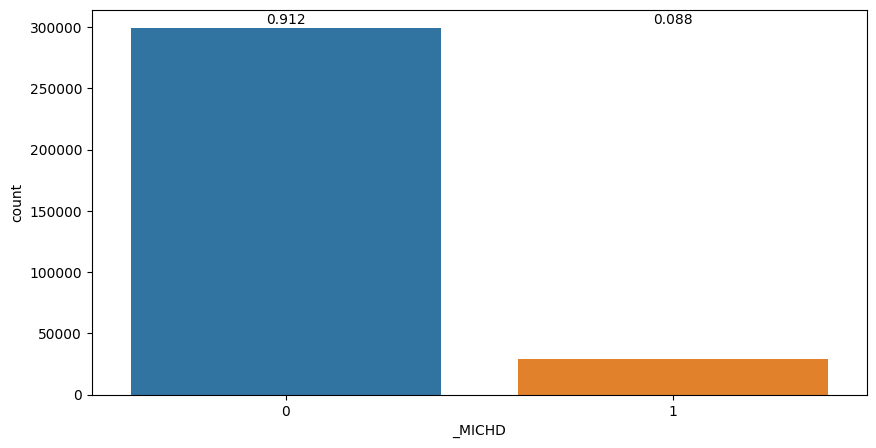

In [135]:
# Visualise proportions of response variable y
sb.countplot(y_train, x = '_MICHD')

y_train_neg = y_train[y_train['_MICHD'] == 0].index
y_train_pos = y_train[y_train['_MICHD'] == 1].index
counts = [round(len(y_train_neg)/ (len(y_train_neg)+len(y_train_pos)), 3), round(len(y_train_pos)/ (len(y_train_neg)+len(y_train_pos)), 3)]

for i, cnt in enumerate(counts):
    plt.text(i, 0.3e6 + cnt + 0.1, str(cnt), ha='center', va='bottom')

### Observation

- Data is heavily skewed towards respondents with no disease
- May have to perform upsampling later on to improve training, especially for classification tasks since skewed dataset can result in bias in predictions

## Evaluation of features, X

- Plot correlation wtih response variable, y
- Shortlisting of most correlated variables
- Correlations between features

In [33]:
# Concatenate response variable y with features
subsetted_X_train.index.name = 'pid'
y_train.index.name = 'pid'
corr_df = pd.merge(subsetted_X_train, y_train, on = 'pid')

print(len(corr_df.columns)) # sanity check

101


In [34]:
corr_df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,EXRACT21,EXEROFT2,EXERHMM2,STRENGTH,LMTJOIN3,ARTHDIS2,ARTHSOCL,JOINPAIN,SEATBELT,_MICHD
pid,,,,,,,,,,,,,,,,,,,,,
0,53,11,11162015,11,16,2015,1100,2015015629,2015015629,NaN,...,98.0,220.0,30.0,105.0,NaN,NaN,NaN,NaN,1.0,0
1,33,12,12152015,12,15,2015,1200,2015004387,2015004387,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,20,10,10202015,10,20,2015,1100,2015005638,2015005638,1.0,...,88.0,NaN,NaN,888.0,2.0,2.0,3.0,5.0,1.0,0
3,42,6,6182015,6,18,2015,1100,2015004694,2015004694,NaN,...,31.0,101.0,300.0,201.0,2.0,2.0,3.0,3.0,1.0,0
4,24,11,11062015,11,6,2015,1100,2015004673,2015004673,1.0,...,76.0,777.0,100.0,888.0,NaN,NaN,NaN,NaN,1.0,0


In [35]:
def identify_categorical(df, threshold = 0.1):
    
    """Function to identify categorical and continuous data columns

    Args:
        df: Dataframe containing columns
        threshold: A float value, threshold value to determine if data column is categorical or continuous

    Returns:
        categorical_cols: List of column names that are categorical
        continuous_cols: List of column names that are continuous
    """
    
    categorical_cols = []
    continuous_cols = []
    
    for col in df.columns:
        # Get back no. of unique values
        unique_values = df[col].nunique()
        # Get total number of values
        total_values = len(df[col])
        
        if unique_values/ total_values < threshold:
            categorical_cols.append(col)
        else:
            continuous_cols.append(col)
            
    return categorical_cols, continuous_cols

In [36]:
"""
Identify no. of columns that contain categorical and continuous variables
"""
categorical_cols, continuous_cols = identify_categorical(corr_df)
print(f'No. of columns: {len(corr_df.columns)}')
print(f'After removing response variable "_MICHD",')
categorical_cols.pop()
print(f'No. of categorical columns: {len(categorical_cols)}')
print(f'No. of continuous columns: {len(continuous_cols)}')

No. of columns: 101
After removing response variable "_MICHD",
No. of categorical columns: 100
No. of continuous columns: 0


Text(0, 0.5, 'Column count')

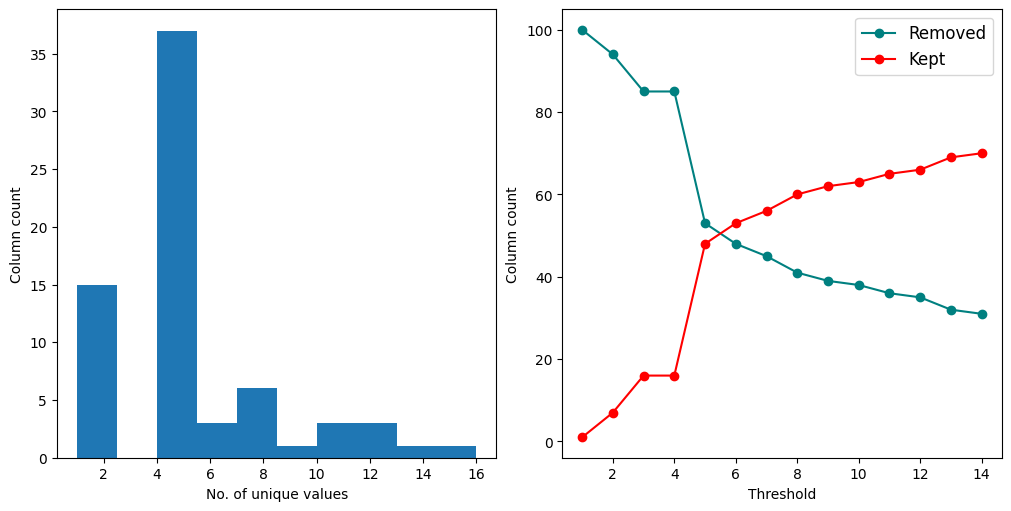

In [37]:
"""
From categorical columns, remove columns with a lot of unique values.These columns are likely to contain 
data such as dates, etc. These would not be helpful with the analysis. Let's perform simple plots to determine
an optimal threshold for the number of unique values a column should have in our analysis.
"""

# Let's use a plot to determine the number of columns to keep
# Idea: Pick a threshold number where the number of categorical columsn removed stabilises

removed_cnt = []
kept_cnt = []
thresholds = [_ for _ in range(1,15)]
for threshold in thresholds:
    removed_categorical_cols = set([col for col in categorical_cols if corr_df[col].nunique() >= threshold])
    kept_categorical_cols = set(corr_df.columns) - removed_categorical_cols
    
    removed_cnt.append(len(list(removed_categorical_cols)))
    kept_cnt.append(len(list(kept_categorical_cols)))

value_cnt = [corr_df[col].nunique() for col in categorical_cols]
value_cnt = [cnt for cnt in value_cnt if cnt <= 20]

plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(1, 2, constrained_layout = True)

axs[0].hist(value_cnt)
axs[0].set_xlabel('No. of unique values', fontsize = 10)
axs[0].set_ylabel('Column count', fontsize = 10)

axs[1].plot(thresholds, removed_cnt, marker='o', color = 'teal', label = 'Removed')
axs[1].plot(thresholds, kept_cnt, marker='o', color = 'red', label = 'Kept')
axs[1].legend(loc='upper right', fontsize = 12)
axs[1].set_xlabel('Threshold', fontsize = 10)
axs[1].set_ylabel('Column count', fontsize = 10)

In [38]:
for i,v in enumerate(kept_cnt):
    print(f'threshold: {i}, columns kept: {v}')

threshold: 0, columns kept: 1
threshold: 1, columns kept: 7
threshold: 2, columns kept: 16
threshold: 3, columns kept: 16
threshold: 4, columns kept: 48
threshold: 5, columns kept: 53
threshold: 6, columns kept: 56
threshold: 7, columns kept: 60
threshold: 8, columns kept: 62
threshold: 9, columns kept: 63
threshold: 10, columns kept: 65
threshold: 11, columns kept: 66
threshold: 12, columns kept: 69
threshold: 13, columns kept: 70


In [39]:
"""
Using a threshold of 10, remove categorical columns with more than 10 unique values
"""

threshold = 10
categorical_cols = [col for col in categorical_cols if corr_df[col].nunique() <= threshold]
print(f'No. of categorical columns kept: {len(categorical_cols)}')

# Get the new dataset with kept categorical columns and response variable, _MICHD
corr_df = corr_df[categorical_cols]
corr_df = pd.merge(corr_df, y_train, on = 'pid')
corr_df.head()

No. of categorical columns kept: 64


,IYEAR,DISPCODE,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,LADULT,CTELNUM1,CELLFON2,...,SMOKDAY2,STOPSMK2,LASTSMK2,USENOW3,EXERANY2,LMTJOIN3,ARTHDIS2,ARTHSOCL,SEATBELT,_MICHD
pid,,,,,,,,,,,,,,,,,,,,,
0,2015,1100,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,1.0,NaN,3.0,1.0,NaN,NaN,NaN,1.0,0
1,2015,1200,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,...,1.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0
2,2015,1100,1.0,1.0,NaN,1.0,2.0,NaN,NaN,NaN,...,3.0,NaN,7.0,3.0,1.0,2.0,2.0,3.0,1.0,0
3,2015,1100,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,1.0,NaN,3.0,1.0,2.0,2.0,3.0,1.0,0
4,2015,1100,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,...,9.0,NaN,NaN,9.0,1.0,NaN,NaN,NaN,1.0,0


In [40]:
"""
Get no. of missing values for each column. Then, identify columns with more than 80% of values being NaN.
These columns will be removed from further analysis.
"""

ttal_cnt = len(corr_df['_MICHD'])
nan_nonmajority_cols = [col for col in corr_df.columns if corr_df[col].isna().sum() / ttal_cnt < 0.8]
print(f'No. of columns with <80% of values being NaN: {len(nan_nonmajority_cols)}')

corr_df = corr_df[nan_nonmajority_cols]
corr_df.head()

No. of columns with <80% of values being NaN: 58


,IYEAR,DISPCODE,CTELENUM,PVTRESD1,STATERES,CELLFON3,CTELNUM1,CELLFON2,CADULT,PVTRESD2,...,SMOKE100,SMOKDAY2,LASTSMK2,USENOW3,EXERANY2,LMTJOIN3,ARTHDIS2,ARTHSOCL,SEATBELT,_MICHD
pid,,,,,,,,,,,,,,,,,,,,,
0,2015,1100,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,...,1.0,1.0,NaN,3.0,1.0,NaN,NaN,NaN,1.0,0
1,2015,1200,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0
2,2015,1100,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,1.0,3.0,7.0,3.0,1.0,2.0,2.0,3.0,1.0,0
3,2015,1100,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,...,1.0,1.0,NaN,3.0,1.0,2.0,2.0,3.0,1.0,0
4,2015,1100,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,9.0,NaN,9.0,1.0,NaN,NaN,NaN,1.0,0


In [41]:
# Drop response variable for now
corr_df = corr_df.drop(['_MICHD'], axis = 1)
corr_df.head()

,IYEAR,DISPCODE,CTELENUM,PVTRESD1,STATERES,CELLFON3,CTELNUM1,CELLFON2,CADULT,PVTRESD2,...,DIFFALON,SMOKE100,SMOKDAY2,LASTSMK2,USENOW3,EXERANY2,LMTJOIN3,ARTHDIS2,ARTHSOCL,SEATBELT
pid,,,,,,,,,,,,,,,,,,,,,
0,2015,1100,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,...,2.0,1.0,1.0,NaN,3.0,1.0,NaN,NaN,NaN,1.0
1,2015,1200,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,2.0,1.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
2,2015,1100,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,2.0,1.0,3.0,7.0,3.0,1.0,2.0,2.0,3.0,1.0
3,2015,1100,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,...,2.0,1.0,1.0,NaN,3.0,1.0,2.0,2.0,3.0,1.0
4,2015,1100,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,2.0,1.0,9.0,NaN,9.0,1.0,NaN,NaN,NaN,1.0


In [73]:
"""
Remove columns that exist for adminstrative purposes and would not help in analysis or not helpful in general.
Columns identified:

1. IYEAR - Year of interview.
2. DISPCODE - Record identification, if the interview was completed)
3. CTELENUM - Telephone number is correct
4. CELLFON3 - Whether this is a cellular telephone
5. CTELNUM1 - Whether this is a cell phone number
6. CELLFON2 - Whether this is a cellular telephone
7. CADULT - Whether person is an adult. Overlaps with age column hence removed
8. CSTATE - Whether person is a resident of state
9. LANDLINE - Whether person has a landline telephone in their home
10. NUMHHOL2 - Whether person has more than one telephone number in their household
11. CPDEMO1 - Whether person has a cell phone for personal use
12. SMOKE100 - Whether person has smoked at least 100 cigarettes in their entire life (SMOKDAY2 makes this column
redundant)
13. LASTSMK2 - Same as SMOKE100

"""

irrelevant_cols = ['IYEAR', 'DISPCODE', 'CTELENUM', 'CELLFON3', 'CTELNUM1', 'CELLFON2', 'CADULT', 'CSTATE',
                   'LANDLINE', 'NUMHHOL2', 'CPDEMO1', 'SMOKE100', 'LASTSMK2']
relevant_cols = list(set(corr_df.columns) - set(irrelevant_cols))
corr_df = corr_df[relevant_cols]
corr_df.head()

,MARITAL,EDUCA,DIABETE3,HAVARTH3,CHCKIDNY,PERSDOC2,SEX,VETERAN3,ARTHDIS2,INTERNET,...,DIFFALON,ASTHMA3,BPHIGH4,STATERES,CHOLCHK,EMPLOY1,USEEQUIP,QLACTLM2,INCOME2,BLOODCHO
pid,,,,,,,,,,,,,,,,,,,,,
0,1,5,3.0,2.0,2,1,2,2.0,NaN,1.0,...,2.0,2,3.0,NaN,1.0,1,2.0,1.0,8.0,1
1,1,4,3.0,2.0,2,1,1,2.0,NaN,2.0,...,2.0,2,1.0,1.0,1.0,1,2.0,2.0,7.0,1
2,1,6,3.0,1.0,2,1,2,2.0,2.0,1.0,...,2.0,2,3.0,1.0,1.0,1,2.0,2.0,99.0,1
3,1,4,3.0,1.0,2,1,2,2.0,2.0,2.0,...,2.0,2,3.0,NaN,4.0,7,2.0,2.0,99.0,1
4,9,9,3.0,2.0,2,9,1,1.0,NaN,1.0,...,2.0,2,3.0,1.0,3.0,9,2.0,2.0,99.0,1


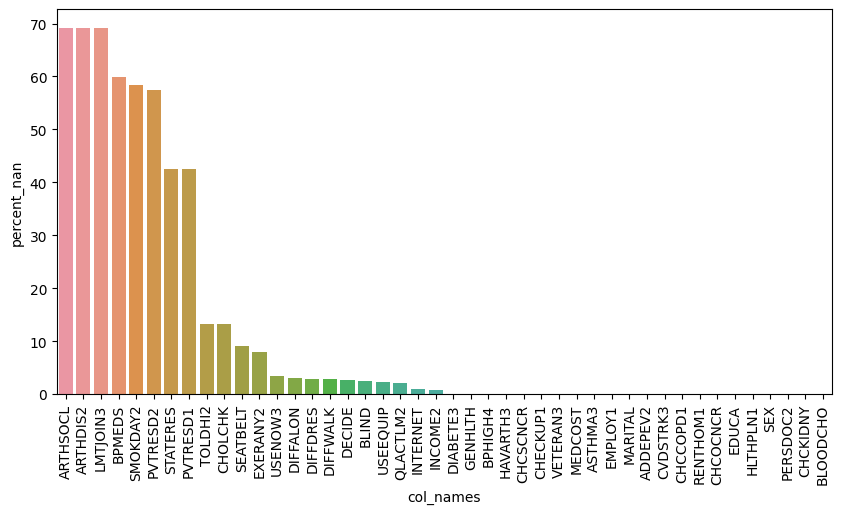

In [74]:
# Get percentage of NaN values for the 57 feature columns
cols = list(corr_df.columns)

nan_cnt = [corr_df[col].isna().sum() for col in corr_df.columns]
ttal_cnt = [len(corr_df[col]) for col in corr_df.columns]
percent_nan = [(nan_cnt[i]/ ttal_cnt[i])*100 for i in range(len(nan_cnt))]

d = {'col_names': cols, 'nan_cnt': nan_cnt, 'ttal_cnt': ttal_cnt, 'percent_nan': percent_nan}
nan_df = pd.DataFrame(data = d)

nan_df_copy = nan_df.copy()
nan_df_copy = nan_df_copy.sort_values('percent_nan', ascending = False).reset_index()

plot = sb.barplot(nan_df_copy, y = 'percent_nan', x = 'col_names', order = nan_df_copy['col_names'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

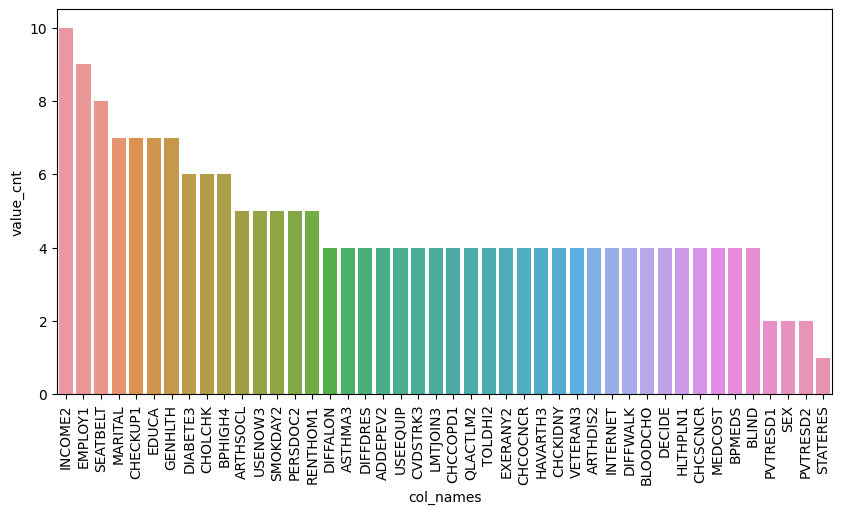

In [75]:
# Get number of unique values for each of the 57 feature columns

cols = list(corr_df.columns)
value_cnt = [corr_df[col].nunique() for col in corr_df.columns]

d = {'col_names': cols, 'value_cnt': value_cnt}
value_cnt_df = pd.DataFrame(data = d)

value_cnt_df_copy = value_cnt_df.copy()
value_cnt_df_copy = value_cnt_df_copy.sort_values('value_cnt', ascending = False).reset_index()

plot = sb.barplot(value_cnt_df_copy, y = 'value_cnt', x = 'col_names', order = value_cnt_df_copy['col_names'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

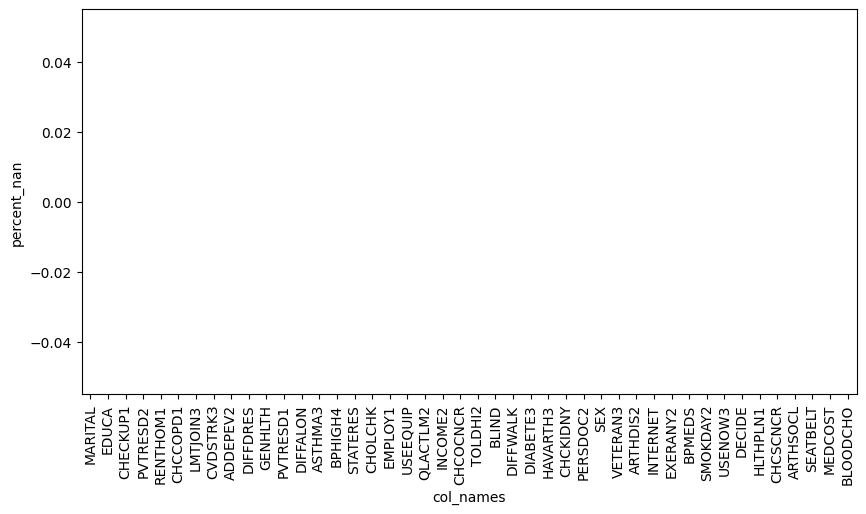

In [77]:
"""
Fill Refused/ missing values to Don't Know/ Not Sure and reformat formatting of refused/ missing values/ Dont't Know/
Not Sure for some columns

Columns that have to change refused (indicated by 9)/ missing values to Don't know/ Not sure(indicated by 7):
1. MARITAL - Change 9 to 7
2. EDUCA - Change 9 to 7
3. EMPLOY1 - Change 9 to 7
4. INCOME2 - Change 77, 99 and BLANK to 7 (Possibility to convert categorical to column and fill missing values with KMeans)
"""
# Fill NaN values, '9's, '77's and '99's with 7
corr_df = corr_df.apply(lambda col: col.fillna(7))
corr_df = corr_df.replace(9, 7)
corr_df = corr_df.replace(77, 7)
corr_df = corr_df.replace(99, 7)

# Check percentage of NaN values again
cols = list(corr_df.columns)

nan_cnt = [corr_df[col].isna().sum() for col in corr_df.columns]
ttal_cnt = [len(corr_df[col]) for col in corr_df.columns]
percent_nan = [(nan_cnt[i]/ ttal_cnt[i])*100 for i in range(len(nan_cnt))]

d = {'col_names': cols, 'nan_cnt': nan_cnt, 'ttal_cnt': ttal_cnt, 'percent_nan': percent_nan}
nan_df = pd.DataFrame(data = d)

nan_df_copy = nan_df.copy()
nan_df_copy = nan_df_copy.sort_values('percent_nan', ascending = False).reset_index()

plot = sb.barplot(nan_df_copy, y = 'percent_nan', x = 'col_names', order = nan_df_copy['col_names'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

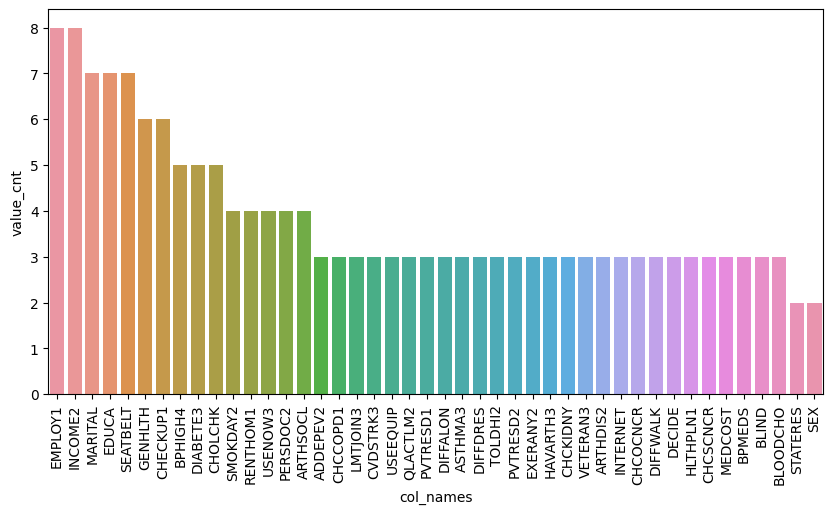

In [78]:
# Check number of unique values for each column again
cols = list(corr_df.columns)
value_cnt = [corr_df[col].nunique() for col in corr_df.columns]

d = {'col_names': cols, 'value_cnt': value_cnt}
value_cnt_df = pd.DataFrame(data = d)

value_cnt_df_copy = value_cnt_df.copy()
value_cnt_df_copy = value_cnt_df_copy.sort_values('value_cnt', ascending = False).reset_index()

plot = sb.barplot(value_cnt_df_copy, y = 'value_cnt', x = 'col_names', order = value_cnt_df_copy['col_names'])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

## Generate one-hot encoding binary features to perform biserial correlation computation

In [79]:
"""
Transform categorical columns into binary columns using sklearn.preprocessing OneHotEncoder
"""

from sklearn.preprocessing import OneHotEncoder

categorical_cols = corr_df.columns

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse = False)

# Transform the categorical columns
encoded_corr_df = encoder.fit_transform(corr_df[categorical_cols])

# Create a DataFrame with the encoded columns
encoded_corr_df = pd.DataFrame(encoded_corr_df, columns=encoder.get_feature_names_out(categorical_cols))

# Combine the new DataFrame with the original one
combined_corr_df = pd.concat([corr_df, encoded_corr_df], axis=1)

# Drop the original categorical columns
encoded_corr_df = combined_corr_df.drop(categorical_cols, axis=1)

encoded_corr_df.head()

/opt/jlab-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,MARITAL_1,MARITAL_2,MARITAL_3,MARITAL_4,MARITAL_5,MARITAL_6,MARITAL_7,EDUCA_1,EDUCA_2,EDUCA_3,...,INCOME2_2.0,INCOME2_3.0,INCOME2_4.0,INCOME2_5.0,INCOME2_6.0,INCOME2_7.0,INCOME2_8.0,BLOODCHO_1,BLOODCHO_2,BLOODCHO_7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [80]:
"""
Add back response variable column and compute correlation coefficient with each variable
"""

encoded_corr_df.index.name = 'pid'
encoded_corr_df = pd.merge(encoded_corr_df, y_train, on = 'pid')
encoded_corr_df.head()

,MARITAL_1,MARITAL_2,MARITAL_3,MARITAL_4,MARITAL_5,MARITAL_6,MARITAL_7,EDUCA_1,EDUCA_2,EDUCA_3,...,INCOME2_3.0,INCOME2_4.0,INCOME2_5.0,INCOME2_6.0,INCOME2_7.0,INCOME2_8.0,BLOODCHO_1,BLOODCHO_2,BLOODCHO_7,_MICHD
pid,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [96]:
"""
Have too many feature variables. Will simply check correlation with our response variable rather than plotting
a heatmap
"""

corr_matrix = encoded_corr_df.corr()

In [97]:
threshold = 0.1

all_corrs = corr_matrix['_MICHD']
filtered_corrs = all_corrs[(all_corrs > threshold) | (all_corrs < -threshold)]
sorted_corrs = filtered_corrs.sort_values(ascending = False)
print(sorted_corrs.to_string())

_MICHD          1.000000
BPMEDS_1.0      0.230243
BPHIGH4_1.0     0.216722
DIFFWALK_1.0    0.212343
CVDSTRK3_1      0.205651
TOLDHI2_1.0     0.191786
USEEQUIP_1.0    0.190659
GENHLTH_5.0     0.190036
CHCCOPD1_1      0.185009
QLACTLM2_1.0    0.183879
DIABETE3_1.0    0.180166
HAVARTH3_1.0    0.167148
EMPLOY1_7       0.165497
LMTJOIN3_1.0    0.150058
INTERNET_2.0    0.147492
GENHLTH_4.0     0.143859
DIFFALON_1.0    0.137909
CHCKIDNY_1      0.133746
CHOLCHK_1.0     0.133154
ARTHSOCL_1.0    0.127774
VETERAN3_1.0    0.119684
EMPLOY1_8       0.119483
DIFFDRES_1.0    0.116388
MARITAL_3       0.112971
ARTHDIS2_1.0    0.112604
BLIND_1.0       0.103649
SMOKDAY2_3.0    0.102091
SMOKDAY2_7.0   -0.106378
GENHLTH_1.0    -0.109442
GENHLTH_2.0    -0.113499
DIFFALON_2.0   -0.114540
VETERAN3_2.0   -0.118872
TOLDHI2_2.0    -0.126920
CHCKIDNY_2     -0.136335
INTERNET_1.0   -0.143960
ARTHDIS2_7.0   -0.150869
ARTHSOCL_7.0   -0.154784
LMTJOIN3_7.0   -0.156584
EMPLOY1_1      -0.165723
HAVARTH3_2.0   -0.167531
